In [1]:
# y_seq_len + merged_future_prediction
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
import os
import yfinance as yf
import timeit
import datetime
import calendar
import warnings
from torch.nn.modules.transformer import TransformerEncoderLayer, TransformerEncoder
from torch.nn.modules.transformer import TransformerDecoder, TransformerDecoderLayer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from sklearn.ensemble import BaggingClassifier


warnings.filterwarnings("ignore", category=FutureWarning)

def create_sequences(data, seq_len, use_target=True):
    X = []
    y = []
    data = data.values  # This line is added
    for i in range(seq_len, data.shape[0]):
        X.append(data[i-seq_len:i, :])
        if use_target:
            y.append(data[i:i+1, -1])
        else: 
            y.append(data[i:i+1, :]) 

    X = np.array(X)
    y = np.array(y)
    return X, y

class DecoderOnlyTransformerModel(nn.Module):
    def __init__(self, n_features, nhead=None, nhid=None, nlayers=None, dropout=None,
                 l1_regularization=0, l2_regularization=0,
                 activation_function=None):
        super(DecoderOnlyTransformerModel, self).__init__()

        self.pos_encoder = nn.Sequential(
            nn.Linear(n_features, nhid),
            activation_function,
            nn.Linear(nhid, nhid),
            activation_function
        )

        decoder_layers = TransformerDecoderLayer(nhid, nhead)
        self.transformer_decoder = TransformerDecoder(decoder_layers,nlayers)

        self.decoder = nn.Linear(nhid,1)

        self.l1_regularization = l1_regularization
        self.l2_regularization = l2_regularization

    def init_weights(self):
        # initrange = 0.1
        nn.init.xavier_uniform_(self.pos_encoder[0].weight)
        nn.init.xavier_uniform_(self.pos_encoder[2].weight)
        self.decoder.bias.data.zero_()
        nn.init.xavier_uniform_(self.decoder.weight)

    def regularization_loss(self):
        l1_loss = 0
        l2_loss = 0
        for param in self.parameters():
            l1_loss += torch.norm(param, 1)
            l2_loss += torch.norm(param, 2) ** 2
        return self.l1_regularization * l1_loss + self.l2_regularization * l2_loss

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x):
        x = self.pos_encoder(x)

        # Generating target mask
        tgt_mask = self.generate_square_subsequent_mask(x.size(0)).to(x.device)

        # Processing the entire input at once
        output = self.transformer_decoder(x, x, tgt_mask=tgt_mask)

        # Apply the final linear layer
        output = self.decoder(output)
        # Selecting the last element from each sequence
        output = output[:, -1, :].squeeze(1)
        return output
    
class TransformerModel(nn.Module):

    def __init__(self, n_features, nhead=None, nhid=None, nlayers=None, dropout=None, l1_regularization=0, l2_regularization=0, activation_function = None):
        super(TransformerModel, self).__init__()

        self.activation_function = activation_function

        # Model architecture
        self.pos_encoder = nn.Sequential(
            nn.Linear(n_features, nhid),
            self.activation_function,
            nn.LayerNorm(nhid),
            nn.Dropout(dropout),
            nn.Linear(nhid, nhid),
            self.activation_function,
            nn.LayerNorm(nhid)
        )
        encoder_layers = TransformerEncoderLayer(nhid, nhead, nhid, dropout,)
        # encoder_layers.self_attn.batch_first = True
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.decoder = nn.Linear(nhid, 1)
        self.l1_regularization = l1_regularization
        self.l2_regularization = l2_regularization
        self.init_weights()

    def init_weights(self):
        for layer in self.pos_encoder:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)

        self.decoder.bias.data.zero_()
        nn.init.xavier_uniform_(self.decoder.weight)

    def regularization_loss(self):
        l1_loss = 0
        l2_loss = 0
        for param in self.parameters():
            l1_loss += torch.norm(param, 1)
            l2_loss += torch.norm(param, 2) ** 2

        return self.l1_regularization * l1_loss + self.l2_regularization * l2_loss

    def forward(self, src):
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output)
        output = output[:, -1:, :].squeeze(1)
        return output    
    
#  For mixed precision training
def train_model(model, X_train, y_train, X_valid, y_valid, n_epochs, optimizer=torch.optim.Adam, criterion=torch.nn.MSELoss, 
                l1_regularization=0, l2_regularization=0, activation_function=None, batch_size=32, patience=10, min_delta=0.0001, learning_rate=1e-3, 
                max_norm=1.0, nan_patience=1, num_workers=12, pin_memory=True, validation_frequency=1, save_directory=None, trial=1, model_ver=None):

    # Enable cuDNN
    torch.backends.cudnn.enabled = True
    torch.cuda.empty_cache()
    optimizer = optimizer(model.parameters(), lr=learning_rate)
    criterion = criterion()

    # Setup GPU device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Put model on GPU
    model.to(device)

    # Create DataLoaders with optimizations
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                            num_workers=num_workers, pin_memory=pin_memory)

    valid_dataset = TensorDataset(X_valid, y_valid)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, 
                            num_workers=num_workers, pin_memory=pin_memory)  

    # Early stopping and NaN stopping parameters
    best_val_loss = float('inf')
    early_stopping_counter = 0
    nan_counter = 0
    stopped_early = False
    train_losses = []
    val_losses = []
 
    # Initialize gradient scaler for mixed precision
    scaler = GradScaler()

    for epoch in range(n_epochs):
        model.train()
        epoch_train_losses = []

        for batch_X_train, batch_y_train in train_loader:
            batch_X_train, batch_y_train = batch_X_train.to(device), batch_y_train.to(device)

            optimizer.zero_grad()

            # Mixed precision context
            with autocast():
                output = model(batch_X_train)
                loss = criterion(output, batch_y_train)
                reg_loss = model.regularization_loss()
                total_loss = loss + reg_loss

            if torch.isnan(loss):
                nan_counter += 1
                if nan_counter >= nan_patience:
                    print(f"Training stopped early at epoch {epoch} due to NaNs in loss")
                    stopped_early = True
                    break
            else:
                nan_counter = 0

            # Gradient scaling for mixed precision
            scaler.scale(total_loss).backward()
            scaler.unscale_(optimizer)  # For gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            scaler.step(optimizer)
            scaler.update()

            epoch_train_losses.append(total_loss.item())

        if stopped_early:
            break

        train_losses.append(np.mean(epoch_train_losses))

        # Validation (can be done less frequently to save time)
        if epoch % validation_frequency == 0:  
            model.eval()
            epoch_val_losses = []
            with torch.no_grad():
                for batch_X_valid, batch_y_valid in valid_loader:
                    batch_X_valid, batch_y_valid = batch_X_valid.to(device), batch_y_valid.to(device)
                    valid_output = model(batch_X_valid)
                    val_loss = criterion(valid_output, batch_y_valid)
                    epoch_val_losses.append(val_loss.item())

            val_losses.append(np.mean(epoch_val_losses))

            print(f"Epoch {epoch}: Train Loss = {train_losses[-1]:.5f}, Val Loss = {val_losses[-1]:.5f}")

            # Early stopping check
            if val_losses[-1] < best_val_loss - min_delta:
                best_val_loss = val_losses[-1]
                early_stopping_counter = 0
                # Save the model
                if save_directory:
                    save_path = os.path.join(save_directory, f"model_ver{model_ver}_trial{trial}_epoch{epoch}.pt")
                else:
                    save_path = f"model_trial_{trial}.pt"

                torch.save(model, save_path)
                print(f"Validation loss improved to {best_val_loss:.5f} at epoch {epoch}, saving model...")
            else:
                early_stopping_counter += 1

            if early_stopping_counter >= patience:
                print("Early stopping triggered due to no improvement in validation loss.")
                break

    return train_losses, val_losses, stopped_early

def plot_results(train_losses, val_losses, trial, save_directory=None):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train Loss', 'Valid Loss'])
    plt.title(f'Train and Valid Losses (Trial {trial+1})')

    if save_directory:
        save_path = os.path.join(save_directory, f"loss_plot_trial_{trial}.png")
        plt.savefig(save_path)

    plt.show()

def model_save(n_trials=1, model_save=True, save_directory=None, plot_loss=True, output_file_path=None, model_ver=None):

    if save_directory and not os.path.exists(save_directory):
        os.makedirs(save_directory)

    all_results_params = []

    for trial in range(n_trials):
        print(f"Trial {trial + 1} of {n_trials}")

        start = timeit.default_timer()

        # seq_len = random.choice(range(3, 6))
        # # nhead = random.choice(range(20, 21))
        # nhid = random.choice(range(5000, 5001))
        # nlayers = random.choice(range(1, 2))
        # # activation_function = random.choice([torch.nn.Tanh(), torch.nn.Sigmoid(), torch.nn.ELU(), torch.nn.ReLU(), torch.nn.LeakyReLU(negative_slope=0.01)])
        # # activation_function = random.choice([torch.nn.GELU(), torch.nn.SiLU()])
        # # activation_function = random.choice([torch.nn.Tanh()])
        # # activation_function = random.choice([torch.nn.Mish()])
        # dropout = 0 * random.choice(range(10, 11))
        # optimizer = random.choice([torch.optim.AdamW])
        # criterion = random.choice([torch.nn.SmoothL1Loss])
        # # criterion = random.choice([torch.nn.MSELoss, torch.nn.L1Loss, torch.nn.KLDivLoss])
        # n_epochs = random.choice(range(300, 501))
        # batch_size = random.choice(range(256, 257))
        # learning_rate = 0.00001 * random.choice(range(10, 11))
        # patience = random.choice(range(30, 31))
        # min_delta = 0.00001 * random.choice(range(1, 2))
        # l1_regularization = 0.0000001 * random.choice(range(4, 5))
        # l2_regularization = l1_regularization

        seq_len = random.choice(range(10, 11))
        nhead = random.choice(range(21, 31))
        nhid = nhead * random.choice(range(21, 31))
        nlayers = random.choice(range(1, 2))
        # activation_function = random.choice([torch.nn.Tanh(), torch.nn.Sigmoid(), torch.nn.ELU(), torch.nn.ReLU(), torch.nn.LeakyReLU(negative_slope=0.01)])
        # activation_function = random.choice([torch.nn.GELU(), torch.nn.SiLU()])
        # activation_function = random.choice([torch.nn.Tanh(), torch.nn.ELU(), torch.nn.Mish()])
        # activation_function = random.choice([torch.nn.Tanh()])
        # dropout = 0.01 * random.choice(range(13, 14))
        # optimizer = random.choice([torch.optim.Adam])
        # criterion = random.choice([torch.nn.SmoothL1Loss])
        # # criterion = random.choice([torch.nn.MSELoss, torch.nn.L1Loss, torch.nn.KLDivLoss, torch.nn.SmoothL1Loss])
        # n_epochs = random.choice(range(200, 201))
        # batch_size = random.choice(range(128, 129))
        # learning_rate = 0.00001 * random.choice(range(10, 11))
        # patience = random.choice(range(10, 11))
        # min_delta = 0.00001 * random.choice(range(1, 2))
        # l1_regularization = 0.0000001 * random.choice(range(20, 21))
        # l2_regularization = l1_regularization
        activation_function = random.choice([torch.nn.Tanh(), torch.nn.ELU(), torch.nn.Mish()])
        dropout = 0.01 * random.choice(range(5, 21))
        optimizer = random.choice([torch.optim.Adam])
        criterion = random.choice([torch.nn.SmoothL1Loss])
        # criterion = random.choice([torch.nn.MSELoss, torch.nn.L1Loss, torch.nn.KLDivLoss, torch.nn.SmoothL1Loss])
        n_epochs = random.choice(range(200, 201))
        batch_size = random.choice(range(128, 1024))
        learning_rate = 0.00001 * random.choice(range(5, 21))
        patience = random.choice(range(3, 4))
        min_delta = 0.00001 * random.choice(range(1, 11))
        l1_regularization = 0.0000001 * random.choice(range(20, 51))
        l2_regularization = l1_regularization

        # Load tensors
        X_train = torch.load(os.path.join(output_file_path, 'X_train.pt'))
        y_train = torch.load(os.path.join(output_file_path, 'y_train.pt'))
        X_valid = torch.load(os.path.join(output_file_path, 'X_valid.pt'))
        y_valid = torch.load(os.path.join(output_file_path, 'y_valid.pt'))

        # Initialize the model
        if model_ver == 'Transformer':
            model = TransformerModel(n_features=X_train.shape[2], nhead=nhead, nhid=nhid, nlayers=nlayers, activation_function=activation_function, dropout=dropout,
                l1_regularization=l1_regularization, l2_regularization=l2_regularization)
        elif model_ver == 'Decoder':
            model = DecoderOnlyTransformerModel(n_features=X_train.shape[2], nhead=nhead, nhid=nhid, nlayers=nlayers, activation_function=activation_function, dropout=dropout,
            l1_regularization=l1_regularization, l2_regularization=l2_regularization)

        # Train the model
        train_losses, val_losses, stopped_early = train_model(model, X_train, y_train, X_valid, y_valid, n_epochs, optimizer=optimizer, criterion=criterion,
                                                              batch_size=batch_size, patience=patience, min_delta=min_delta, learning_rate=learning_rate, trial=trial, 
                                                              model_ver=model_ver, save_directory=save_directory)
        # Check if training stopped early due to NaNs or not
        if stopped_early:
            print(f"Random search iteration {trial+1} stopped early due to NaNs in loss")
            # Using 'continue' here will skip the remaining statements of the current iteration and proceed to the next iteration
            continue

        if plot_loss:
            plot_results(train_losses, val_losses, trial, save_directory=save_directory)

        # # Save the model
        # if model_save:
        #     if save_directory:
        #         save_path = os.path.join(save_directory, f"model_trial_{trial}.pt")
        #     else:
        #         save_path = f"model_trial_{trial}.pt"
        #     torch.save(model, save_path)

        # Add the results to the results dataframe
        params = {"seq_len": seq_len, "nhead": nhead, "nhid": nhid, "nlayers": nlayers, "activation_function": activation_function,
                "optimizer": optimizer, "criterion": criterion, "dropout": dropout, "n_epochs": n_epochs,
                "batch_size": batch_size, "learning_rate": learning_rate, "patience": patience, "min_delta": min_delta,
                "l1_regularization": l1_regularization, "l2_regularization": l2_regularization,
                }

        results_params = {**params, "trial": trial+1, "train loss": train_losses[-1], "valid loss": val_losses[-1]}

        all_results_params.append(results_params)
        all_results_params_df = pd.DataFrame(all_results_params)

        if save_directory:
            all_results_params_df.to_csv(os.path.join(save_directory, f"all_results_params_{trial}.csv"))

        end = timeit.default_timer()
        # Calculate and print duration
        duration = end - start
        print(f"Execution Time of Trial {trial + 1} of {n_trials} is: {duration} seconds")

    return all_results_params_df

Trial 1 of 5
Epoch 0: Train Loss = 0.10882, Val Loss = 0.00896
Validation loss improved to 0.00896 at epoch 0, saving model...
Epoch 1: Train Loss = 0.03492, Val Loss = 0.00833
Validation loss improved to 0.00833 at epoch 1, saving model...
Epoch 2: Train Loss = 0.02131, Val Loss = 0.00705
Validation loss improved to 0.00705 at epoch 2, saving model...
Epoch 3: Train Loss = 0.01513, Val Loss = 0.00713
Epoch 4: Train Loss = 0.01045, Val Loss = 0.00674
Validation loss improved to 0.00674 at epoch 4, saving model...
Epoch 5: Train Loss = 0.00878, Val Loss = 0.00708
Epoch 6: Train Loss = 0.00879, Val Loss = 0.00699
Epoch 7: Train Loss = 0.00724, Val Loss = 0.00680
Early stopping triggered due to no improvement in validation loss.


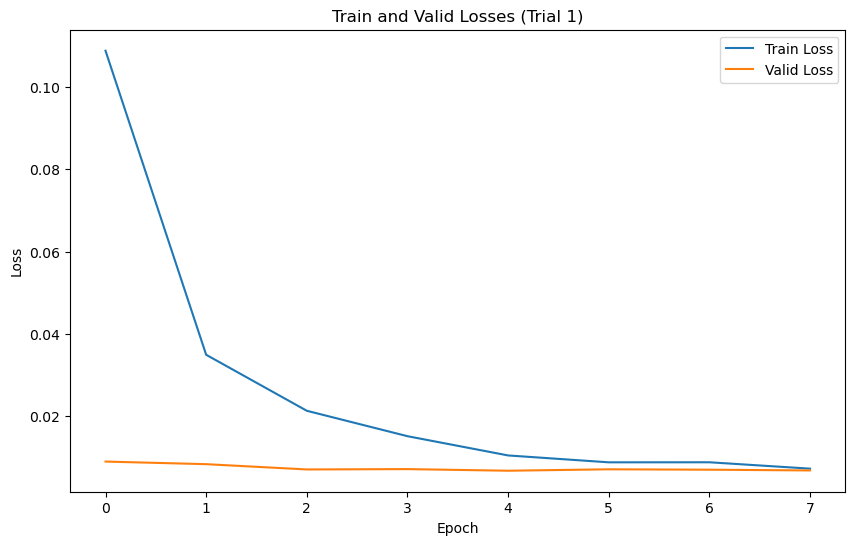

Execution Time of Trial 1 of 5 is: 1143.8285889829858 seconds
Trial 2 of 5
Epoch 0: Train Loss = 0.08189, Val Loss = 0.00699
Validation loss improved to 0.00699 at epoch 0, saving model...
Epoch 1: Train Loss = 0.01376, Val Loss = 0.00707
Epoch 2: Train Loss = 0.00985, Val Loss = 0.00770
Epoch 3: Train Loss = 0.00864, Val Loss = 0.00680
Validation loss improved to 0.00680 at epoch 3, saving model...
Epoch 4: Train Loss = 0.00787, Val Loss = 0.00686
Epoch 5: Train Loss = 0.00726, Val Loss = 0.00681
Epoch 6: Train Loss = 0.00677, Val Loss = 0.00698
Early stopping triggered due to no improvement in validation loss.


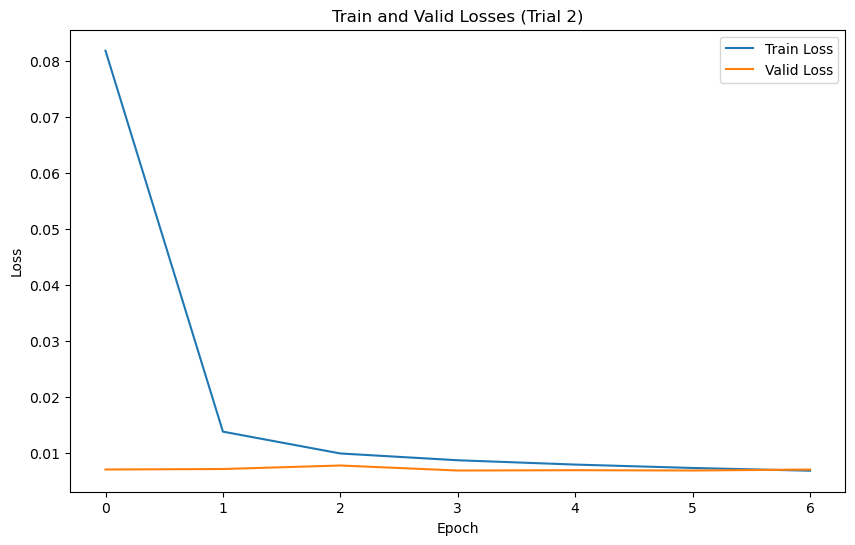

Execution Time of Trial 2 of 5 is: 929.9887601640075 seconds
Trial 3 of 5
Epoch 0: Train Loss = 0.09688, Val Loss = 0.00780
Validation loss improved to 0.00780 at epoch 0, saving model...
Epoch 1: Train Loss = 0.01776, Val Loss = 0.00849
Epoch 2: Train Loss = 0.01264, Val Loss = 0.00707
Validation loss improved to 0.00707 at epoch 2, saving model...
Epoch 3: Train Loss = 0.01012, Val Loss = 0.00712
Epoch 4: Train Loss = 0.00849, Val Loss = 0.00735
Epoch 5: Train Loss = 0.00735, Val Loss = 0.00682
Validation loss improved to 0.00682 at epoch 5, saving model...
Epoch 6: Train Loss = 0.00657, Val Loss = 0.00679
Validation loss improved to 0.00679 at epoch 6, saving model...
Epoch 7: Train Loss = 0.00598, Val Loss = 0.00705
Epoch 8: Train Loss = 0.00558, Val Loss = 0.00702
Epoch 9: Train Loss = 0.00530, Val Loss = 0.00701
Early stopping triggered due to no improvement in validation loss.


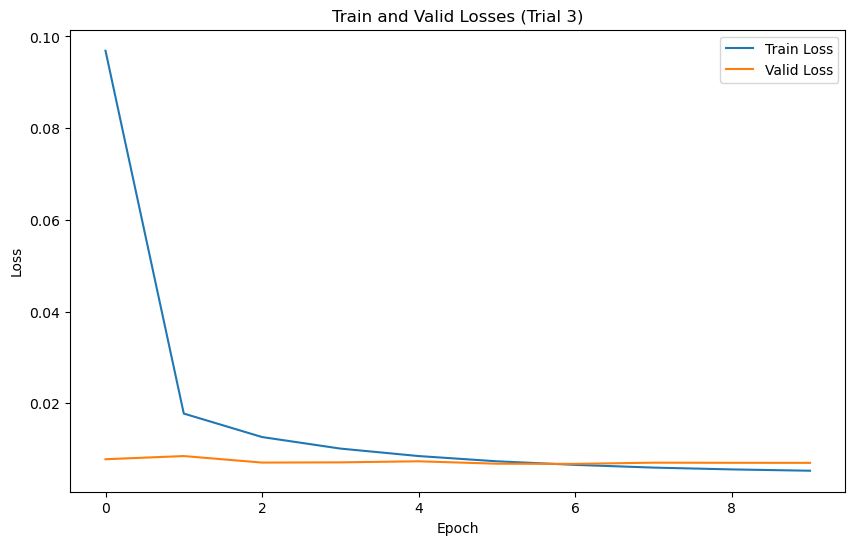

Execution Time of Trial 3 of 5 is: 1155.9296588639845 seconds
Trial 4 of 5
Epoch 0: Train Loss = 0.14889, Val Loss = 0.01019
Validation loss improved to 0.01019 at epoch 0, saving model...
Epoch 1: Train Loss = 0.06222, Val Loss = 0.00786
Validation loss improved to 0.00786 at epoch 1, saving model...
Epoch 2: Train Loss = 0.03727, Val Loss = 0.00736
Validation loss improved to 0.00736 at epoch 2, saving model...
Epoch 3: Train Loss = 0.02619, Val Loss = 0.00688
Validation loss improved to 0.00688 at epoch 3, saving model...
Epoch 4: Train Loss = 0.01975, Val Loss = 0.00709
Epoch 5: Train Loss = 0.01616, Val Loss = 0.00676
Validation loss improved to 0.00676 at epoch 5, saving model...
Epoch 6: Train Loss = 0.01389, Val Loss = 0.00679
Epoch 7: Train Loss = 0.01220, Val Loss = 0.00668
Validation loss improved to 0.00668 at epoch 7, saving model...
Epoch 8: Train Loss = 0.01085, Val Loss = 0.00668
Epoch 9: Train Loss = 0.00971, Val Loss = 0.00680
Epoch 10: Train Loss = 0.00872, Val Loss 

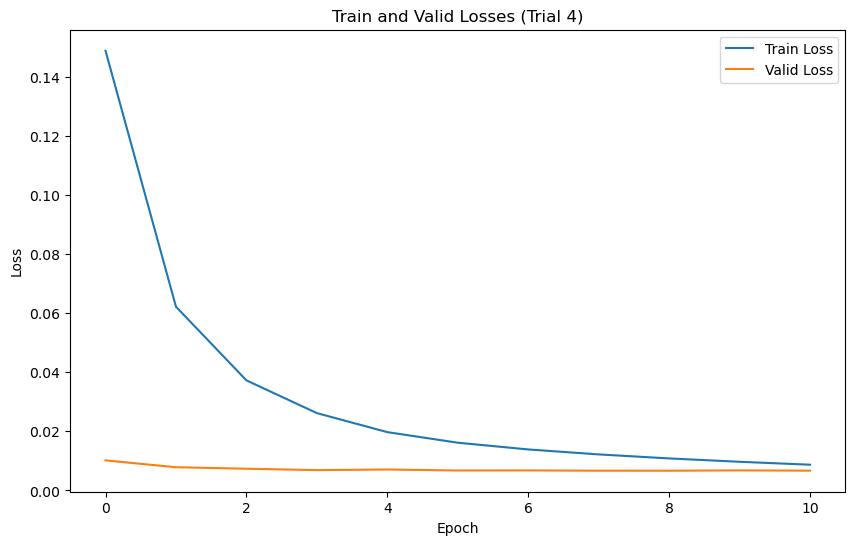

Execution Time of Trial 4 of 5 is: 1179.9340213559917 seconds
Trial 5 of 5
Epoch 0: Train Loss = 0.13245, Val Loss = 0.01341
Validation loss improved to 0.01341 at epoch 0, saving model...
Epoch 1: Train Loss = 0.04654, Val Loss = 0.00980
Validation loss improved to 0.00980 at epoch 1, saving model...
Epoch 2: Train Loss = 0.02483, Val Loss = 0.00862
Validation loss improved to 0.00862 at epoch 2, saving model...
Epoch 3: Train Loss = 0.01716, Val Loss = 0.00827
Validation loss improved to 0.00827 at epoch 3, saving model...
Epoch 4: Train Loss = 0.01297, Val Loss = 0.00751
Validation loss improved to 0.00751 at epoch 4, saving model...
Epoch 5: Train Loss = 0.01040, Val Loss = 0.00766
Epoch 6: Train Loss = 0.00875, Val Loss = 0.00733
Validation loss improved to 0.00733 at epoch 6, saving model...
Epoch 7: Train Loss = 0.00758, Val Loss = 0.00676
Validation loss improved to 0.00676 at epoch 7, saving model...
Epoch 8: Train Loss = 0.00672, Val Loss = 0.00671
Epoch 9: Train Loss = 0.006

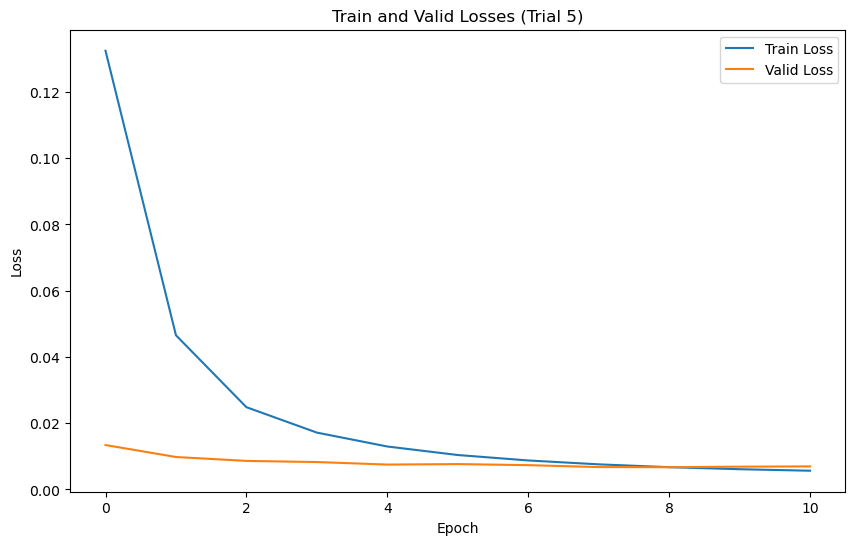

Execution Time of Trial 5 of 5 is: 1507.464481879957 seconds


In [2]:
n_trials = 5
model_ver='Transformer'
# validation_frequency = 2

# batch_size_data = 100000

save_directory = "/home/predict_price/stock_price/save_model/Direction/ver4/ver4_seq_10_split_0.7_SP_list_2001_2"
# output_file_path_params = "/home/predict_price/stock_price/save_model/ver5.8/ver5.8_decoder_no_split/ver5.8_decoder_no_split"
output_file_path = "/home/predict_price/stock_price/data_save/Direction/ver4/ver4_seq_10_split_0.7_SP_list_2001"
all_results_params_df = model_save(n_trials=n_trials, model_save=True, save_directory=save_directory, plot_loss=True, output_file_path=output_file_path, model_ver=model_ver)
# Save results_df
all_results_params_df.to_csv(f'{save_directory}_all_results_params_df.csv', index=True)